In [3]:
from typing import NamedTuple, Tuple
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

# 1. Introduction

The goal of this project is to build a mixture model for collaborative filtering. We are given a data matrix containing movie ratings made by users where the matrix is extracted from a much larger Netflix database. Any particular user has rated only a small fraction of the movies so the data matrix is only partially filled. The goal is to predict all the remaining entries of the matrix.

We will use mixtures of Gaussians to solve this problem. The model assumes that each user's rating profile is a sample from a mixture model. In other words, we have $K$ possible types of users and, in the context of each user, we must sample a user type and then the rating profile from the Gaussian distribution associated with the type. We will use the Expectation Maximization (EM) algorithm to estimate such a mixture from a partially observed rating matrix. The EM algorithm proceeds by iteratively assigning (softly) users to types (E-step) and subsequently re-estimating the Gaussians associated with each type (M-step). Once we have the mixture, we can use it to predict values for all the missing entries in the data matrix.

# 2. K-Means

We will compare the clustering obtained via K-means to the (soft) clustering induced by EM. In order to do so, our K-means algorithm will differ a bit from the one you learned. Here, the means are estimated exactly as before but the algorithm returns additional information. More specifically, we use the resulting clusters of points to estimate a Gaussian model for each cluster. Thus, our K-means algorithm actually returns a mixture model where the means of the component Gaussians are the K centroids computed by the K-means algorithm. This is to make it such that we can now directly plot and compare solutions returned by the two algorithms as if they were both estimating mixtures. 

First, because both K-means and EM will employ a Gaussian mixture model, we implement the class `GaussianMixture` below which contains the mean, variance and weight of each cluster.

In [4]:
class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component

We then initialize the Gaussian mixture model using the `init` function. The function first selects $K$ random points as means and then computes the variance accordingly. The initialization also assumes uniform assignments (i.e., the clusters are assigned the same weights). These are then used to initialize a `GaussianMixture`.

In [5]:
def init(X: np.ndarray, K: int,
         seed: int = 0) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        mixture: the initialized gaussian mixture
        post: (n, K) array holding the soft counts
            for all components for all examples

    """
    np.random.seed(seed)
    n, _ = X.shape
    p = np.ones(K) / K

    # Select K random points as initial means
    mu = X[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post

Having implemented the helper functions, we are now prepared to implement the k-means algorithm. We will make this implementation analogous to the EM algorithm and separate it into expectation (E) and maximization (M) steps. 

The E-step assigns each datapoint to a Gaussian component. To do this, we take the component with the lowest SSE (sum squared error)/closest mean. Since we know for sure that this point belongs to the given cluster, we change the element in the `post` matrix (which holds the counts for all components for all examples) corresponding to the given component and data point to 1.

In [6]:
def kmeans_estep(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """E-step: Assigns each datapoint to the gaussian component with the
    closest mean

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples

        """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1

    return post

The M-step, on the other hand, updates the Gaussian mixture model. Just as in the lecture, we compute for the following values for all components $j$:

- $\hat{n_{j}} = \sum_{i = 1}^{n} \delta(j|i)$

- $\hat{p_{j}} = \frac{\hat{n_{j}}}{n}$

- $\hat{\mu_{j}} = \frac{\sum_{i = 1}^{n} \delta(j|i) x^{(i)}}{\hat{n_{j}}}$

- $\hat{\sigma^{2}_{j}} = \frac{\sum_{i = 1}^{n} \delta(j|i) ||x^{(i)} - \mu_{j}||^{2}}{\hat{n_{j}}}$

where $\delta(j|i)$ is the element in the $i^{th}$ row and $j^{th}$ column in the `post` matrix and represents whether or not point $i$ (or $x^{(i)})$ is assigned to component $j$.

Along with this, we keep track of the cost of each step. The cost is the cumulative sum of squared errors for all components and is computed as the $\sum_{i = 1}^{n} ||x^{(i)} - \mu_{j}||^{2}$. The cost allows us to determine whether the algorithm is converging or not.

In [7]:
def kmeans_mstep(X: np.ndarray, post: np.ndarray) -> Tuple[GaussianMixture, float]:
    """M-step: Updates the gaussian mixture. Each cluster
    yields a component mean and variance.

    Args: X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        float: the distortion cost for the current assignment
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
        var[j] = sse / (d * n_hat[j])

    return GaussianMixture(mu, var, p), cost

Finally, we have the `run` function which runs the k-means algorithm. Our convergence criteria for this algorithm dictates that we run it for as long as there is a significant difference between the cost of the present step and the cost of the previous step.

In [8]:
def kmeans_run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: distortion cost of the current assignment
    """

    prev_cost = None
    cost = None
    while (prev_cost is None or prev_cost - cost > 1e-4):
        prev_cost = cost
        post = kmeans_estep(X, mixture)
        mixture, cost = kmeans_mstep(X, post)

    return mixture, post, cost

To test these functions out, we start with a toy dataset. We try k-means for different numbers of components (1, 2, 3, 4) and for different seeds (i.e., different random initializations) and take note of the value of $K$ which gives the lowest cost. We plot the result of k-means for the best values of $K$ and the best seeds, using the `plot` helper function shown below.

In [9]:
def plot(X: np.ndarray, mixture: GaussianMixture, post: np.ndarray,
         title: str):
    """Plots the mixture model for 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    ax.set_xlim((-20, 20))
    ax.set_ylim((-20, 20))
    r = 0.25
    color = ["r", "b", "k", "y", "m", "c"]
    for i, point in enumerate(X):
        theta = 0
        for j in range(K):
            offset = percent[i, j] * 360
            arc = Arc(point,
                      r,
                      r,
                      0,
                      theta,
                      theta + offset,
                      edgecolor=color[j])
            ax.add_patch(arc)
            theta += offset
    for j in range(K):
        mu = mixture.mu[j]
        sigma = np.sqrt(mixture.var[j])
        circle = Circle(mu, sigma, color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu = ({:0.2f}, {:0.2f})\n stdv = {:0.2f}".format(
            mu[0], mu[1], sigma)
        ax.text(mu[0], mu[1], legend)
    plt.axis('equal')
    plt.show()

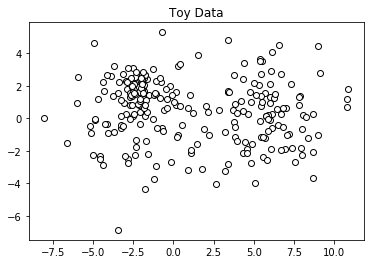

In [20]:
# Load toy dataset
X = np.loadtxt('toy_data.txt')

plt.title("Toy Data")
plt.scatter(X[:, 0], X[:, 1], marker = "o", edgecolor = "black", facecolor = "white")

K-means for K=1, seed=0, cost=5462.297452340001


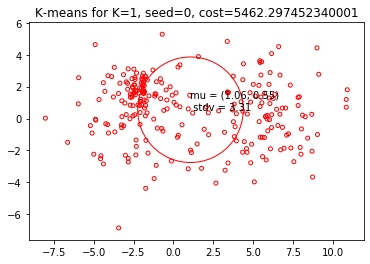

K-means for K=2, seed=0, cost=1684.9079502962372


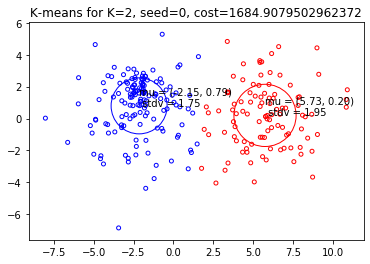

K-means for K=3, seed=4, cost=1329.59486715443


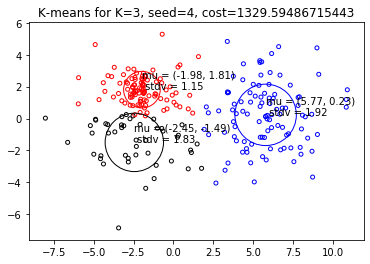

K-means for K=4, seed=4, cost=1035.499826539466


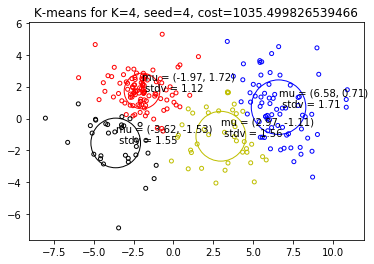

In [21]:
# Run K-means for all values of K and for all seeds
for K in range(1, 5):
    min_cost = None
    best_seed = None
    for seed in range(0, 5):
        mixture, post = init(X, K, seed)
        mixture, post, cost = kmeans_run(X, mixture, post)
        if min_cost is None or cost < min_cost:
            min_cost = cost
            best_seed = seed
        
    mixture, post = init(X, K, best_seed)
    mixture, post, cost = kmeans_run(X, mixture, post)
    title = "K-means for K={}, seed={}, cost={}".format(K, best_seed, min_cost)
    print(title)
    plot(X, mixture, post, title)    

We observe that performing k-means tends to result in evenly spaced clusters despite the actual distribution of the points. This is because k-means attempts to lower the distortion cost. For this to happen, k-means will assign means in such a way that disperses the clusters so that points are as close to their cluster means as possible, lowering the sum of squared errors. 

# 3. Expectation-Maximization (EM) Algorithm

 Recall the Gaussian mixture model presented in class: 
 
 $P(x|\theta) = \sum_{j = 1}^{K} \pi_{j}N(x; \mu_{(j)}, \sigma^{2}_{(j)}I$)
 
where $\theta$ denotes all the parameters in the mixture (means $\mu_{(j)}$, mixing proportions $\pi_{j}$, and variances $\sigma^{2}_{(j)}$). Note here that we now use $\pi_{j}$ instead of $\delta(j|i)$ because instead of hard counts (i.e., a point either belonging to a cluster or not), we will instead use soft counts (i.e., a point having a probability of belonging to each cluster).
 
The goal of the EM algorithm is to estimate these unknown parameters by maximizing the log-likelihood of the observed data $x^{(1)}, \ldots, x^{(n)}$. Starting with some initial guess of the unknown parameters, the algorithm iterates between E- and M-steps. The E-step softly assigns each data point $x^{(1)}$ to mixture components. The M-step takes these soft-assignments as given and finds a new setting of the parameters by maximizing the log-likelihood of the weighted dataset (expected complete log-likelihood). 

We now reimplement the `estep`, `mstep` and `run` functions from earlier but modify them for the EM-algorithm.

In [9]:
def naive_em_estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """
    n, d = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))
    log_likelihood = 0
    
    for i in range(n):
        for j in range(K):
            likelihood = multivariate_normal.pdf(X[i, :], mean = mixture.mu[j, :], cov = mixture.var[j] * np.identity(d))
            post[i, j] = mixture.p[j] * likelihood
        total = post[i, :].sum()
        post[i, :] = post[i, :] / total
        log_likelihood += np.log(total)
    
    return post, log_likelihood

Note in our new `estep` implementation, we compute for the following posterior probability:

$p(j|i) = \frac{p_{j}N(x; \mu_{(j)}, \sigma^{2}_{(j)}I)}{\sum_{j = 1}^{K} p_{j}N(x; \mu_{(j)}, \sigma^{2}_{(j)}I)}$

and store it in the `post` matrix. This represents the probability that point $i$ is assigned to cluster $j$. 

The log-likelihood is computed as follows:

$\sum_{i = 1}^{N} \left( \sum_{j = 1}^{K} p_{j}N(x^{(i)}; \mu_{(j)}, \sigma^{2}_{(j)}I) \right)$

and will play the same role as `cost` from earlier (in the convergence criteria).

In [10]:
def naive_em_mstep(X: np.ndarray, post: np.ndarray) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis = 0)
    p = n_hat / n

    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        var[j] = sse / (d * n_hat[j])

    return GaussianMixture(mu, var, p)

As before, the M-step updates the Gaussian mixture model. Just as in the lecture, we compute for the following values for all components $j$:

- $\hat{n_{j}} = \sum_{t = 1}^{n} p(j|i)$

- $\hat{p_{j}} = \frac{\hat{n_{j}}}{n}$

- $\hat{\mu_{j}} = \frac{\sum_{i = 1}^{n} p(j|i) x^{(i)}}{\hat{n_{j}}}$

- $\hat{\sigma^{2}_{j}} = \frac{\sum_{i = 1}^{n} p(j|i) ||x^{(i)} - \mu_{j}||^{2}}{\hat{n_{j}}}$

where $p(j|i)$ is the element in the $i^{th}$ row and $j^{th}$ column in the `post` matrix and represents the probability of point $i$ (or $x^{(i)})$ being assigned to component $j$.

In [13]:
def naive_em_run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    prev_log_likelihood = None
    log_likelihood = None
    while (prev_log_likelihood is None or log_likelihood - prev_log_likelihood > 1e-6 * abs(log_likelihood)):
        prev_log_likelihood = log_likelihood
        post, log_likelihood = naive_em_estep(X, mixture)
        mixture = naive_em_mstep(X, post)

    return mixture, post, log_likelihood

For the `run` function for the EM algorithm, we implement the following convergence criteria: The algorithm converges when new log-likelihood − old log-likelihood $\leq 10^{−6} \cdot $ |new log-likelihood|

We then repeat the runs we did earlier using k-means but employ the EM algorithm instead. Note that instead of getting the $K$ and seed which minimize cost, we now aim to get the parameters for which we get the highest log-likelihood.

EM for K=1, seed=0, log_likelihood=-1307.2234317600937


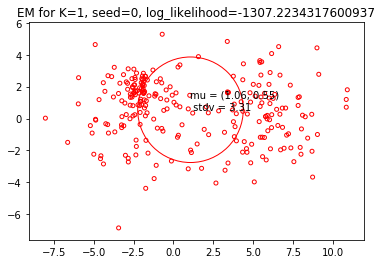

EM for K=2, seed=2, log_likelihood=-1175.7146293666792


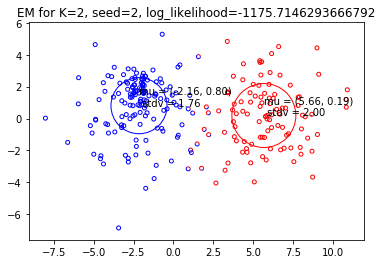

EM for K=3, seed=0, log_likelihood=-1138.8908996872674


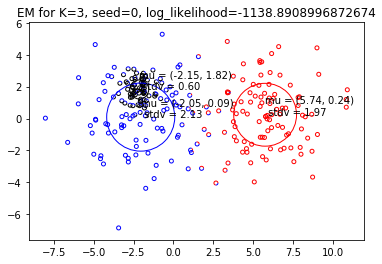

EM for K=4, seed=4, log_likelihood=-1138.6011756994853


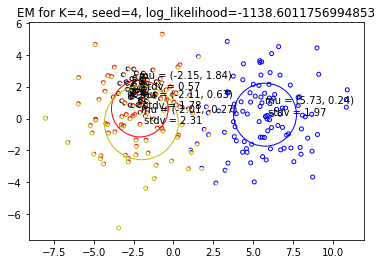

In [18]:
# Load toy dataset
X = np.loadtxt('toy_data.txt')

# Run K-means for all values of K and for all seeds
for K in range(1, 5):
    max_ll = -5e6
    best_seed = None
    for seed in range(0, 5):
        mixture, post = init(X, K, seed)
        mixture, post, ll = naive_em_run(X, mixture, post)
        if ll > max_ll:
            max_ll = ll
            best_seed = seed
        
    mixture, post = init(X, K, best_seed)
    mixture, post, ll = naive_em_run(X, mixture, post)
    title = "EM for K={}, seed={}, log_likelihood={}".format(K, best_seed, max_ll)
    print(title)
    plot(X, mixture, post, title)    

Comparing the results of the k-means algorithm and the EM algorithm, we make the following observations: 

- The $K$ = 1 case is exactly the same since all the data is assigned to the same cluster. 
- The $K$ = 2 case is very similar in terms of cluster mean and point assignment, but since EM uses "soft clustering", some of the points in the middle are effectively assigned to two clusters with differing probabilities.
- The $K$ = 3 case equally spaces the clusters for k-means to minimize the overall distortion cost, but the left two clusters for EM are closely packed with very different variances because EM wants to account for the densely set of points on the left side. Again, as noted, EM employs "soft clustering" so some of the points are assigned to more than one cluster.
- The $K$ = 4 case is similar to the $K$ = 3 case where all of the clusters in k-means are equally spaced, but the EM has significant overlap on the left side. Once again, this is due to the density of points on the left side.

# 4. Bayesian Information Criterion

So far we have simply set the number of mixture components $K$ but this is also a parameter that we must estimate from data. How does the log-likelihood of the data vary as a function of $K$ assuming we avoid locally optimal solutions?

To compensate, we need a selection criterion that penalizes the number of parameters used in the model. The Bayesian information criterion (BIC) is a criterion for model selection. It captures the tradeoff between the log-likelihood of the data, and the number of parameters that the model uses. 

The BIC of a model $M$ is defined as:

$BIC(M)=l−\frac{1}{2}p \log{n}$ 	  	  	 	 

where $l$ is the log-likelihood of the data under the current model (highest log-likelihood we can achieve by adjusting the parameters in the model), $p$ is the number of adjustable parameters, and $n$ is the number of data points. This score rewards a larger log-likelihood, but penalizes the number of parameters used to train the model. In a situation where we wish to select models, we want a model with the the highest BIC.

We implement this computation below in the function `bic`.

In [19]:
def bic(X: np.ndarray, mixture: GaussianMixture,
        log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians

    Args:
        X: (n, d) array holding the data
        mixture: a mixture of spherical gaussian
        log_likelihood: the log-likelihood of the data

    Returns:
        float: the BIC for this mixture
    """
    n, d = X.shape
    K, _ = mixture.mu.shape

    num_param = (K * d) + K + (K - 1)
    BIC = log_likelihood - 0.5 * num_param * np.log(n)
    
    return BIC

# 5. Mixture Models for Matrix Completion

We can now extend our Gaussian mixture model to predict actual movie ratings. Let $X$ again denote the $(n,d)$ data matrix. The rows of this matrix correspond to users and columns specify movies so that `X[u,i]` gives the rating value of user $u$ for movie $i$ (if available). Both $n$ and $d$ are typically quite large. The ratings range from one to five stars and are mapped to integers ${1,2,3,4,5}$. We will set `X[u,i] = 0` whenever the entry is missing.

In a realistic setting, most of the entries of $X$ are missing. For this reason, we define $C_{u}$ as the set of movies (column indexes) that user $u$ has rated and $H_{u}$ as its complement (the set of remaining unwatched/unrated movies we wish to predict ratings for). We use $|C_{u}|$ to denote the number of observed rating values from user $u$. From the point of view of our mixture model, each user $u$ is an example $x^{(u)}$ = `X[u,:]`. But since most of the coordinates of $x^{(u)}$ are missing, we need to focus the model during training on just the observed portion. To this end, we use $x^{(u)}_{C_{u}} = \{ x^{(u)}_{i} i :i \in C_{u} \}$ as the vector of only observed ratings. 

If columns are indexed as ${0, \ldots, d − 1}$, then a user $u$ with a rating vector $x^{(u)} = (5,4,0,0,2)$, where zeros indicate missing values, has $C_{u} = {0,1,4}$, $H_{u} = {2,3}$, and $x^{(u)}_{C_{u}} = (5,4,2)$.

In this part, we will extend our mixture model in two key ways.
- First, we are going to estimate a mixture model based on partially observed ratings.
- Second, since we will be dealing with a large, high-dimensional data set, we will need to be more mindful of numerical underflow issues. To this end, we will perform most of our computations in the log domain. 
   - Remember, $log(a⋅b)=log(a)+log(b)$. This can be useful to remember when a and b are very small – in these cases, addition should result in fewer numerical underflow issues than multiplication.
   - An additional numerical optimization trick that you will find useful is the LogSumExp trick. Assume that we wish to evaluate $y = \log(\exp(x_{1})+ \ldots + \exp(x_{n}))$. We define $x^{∗} = \max \{x_{1}, \ldots, x_{n} \}$. Then, $y = x^{∗} + \log(\exp(x_{1})+ \ldots + \exp(x_{n}))$. This is just another trick to help ensure numerical stability. 

## 5.1 Marginalizing over unobserved coordinates

If $x^{(u)}$ were a complete rating vector, the mixture model from the earlier part would simply say that $P(x^{(u)}|\theta) = \sum_{j = 1}^{K} \pi_{j}N(x^{(u)}; \mu_{(j)}, \sigma^{2}_{(j)}I)$. In the presence of missing values, we must use the marginal probability $P(x^{(u)}_{C_{u}}|\theta)$ that is over only the observed values. This marginal corresponds to integrating the mixture density $P(x^{(u)}|\theta)$ over all the unobserved coordinate values. In our case, this marginal can be computed as follows.

The mixture model for a complete rating vector is written as:

$P(x^{(u)}|\theta) = \sum_{j = 1}^{K} p_{j}N(x^{(u)}; \mu_{(j)}, \sigma^{2}_{(j)}I)$

We can decompose the multivariate spherical Gaussian as a product of univariate Gaussians (since there is no covariance between coordinates).

$P(x^{(u)}|\theta) = \sum_{j = 1}^{K} p_{j} \prod_{i} N(x^{(u)}_{i}; \mu^{(j)}_{i}, (\sigma^{2})^{(j)}_{i})$

$= \sum_{j = 1}^{K} p_{j} \prod_{m \in C_{u}} N(x^{(u)}_{m}; \mu^{(j)}_{m}, (\sigma^{2})^{(j)}_{m})\prod_{m' \in H_{u}} N(x^{(u)}_{m'}; \mu^{(j)}_{m'}, (\sigma^{2})^{(j)}_{m'})$ 


For $m' \in H_{u}$, we can marginalize over all of the unobserved values to get

$\int N(x^{(u)}_{m'}; \mu^{(j)}_{m'}, (\sigma^{2})^{(j)}_{m'}) dx^{(u)}_{m'} = 1$
	 
Thus, our mixture density can be written as

$P(x^{(u)}_{C_{u}}|\theta) = \sum_{j = 1}^{K} p_{j} N(x^{(u)}_{C_{u}}; \mu^{(j)}_{C_{u}}, (\sigma^{2})^{(j)}I_{|C_{u}|\times|C_{u}|})$

where $I_{|C_{u}|\times|C_{u}|}$ is the identity matrix in $|C_{u}|$ dimensions.


## 5.2 Implementing EM for matrix completion

### 5.2.1 Deriving the posterior probability distribution

We need to update our EM algorithm a bit to deal with the fact that the observations are no longer complete vectors. We use Bayes' rule to find an updated expression for the posterior probability $p(j|u)=P(y=j|x_{C_{u}}^{(u)})$:

$p(j\mid u) = \frac{p(u|j)\cdot p(j)}{p(u)}$

$=\frac{p(u|j)\cdot p(j)}{\sum _{j=1}^{K}p(u|j)\cdot p(j)}$

$=\frac{ \pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}}) }{ \sum _{j=1}^{K}\pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}})}$	 

This is the soft assignment of data point $u$ to cluster $j$.

### 5.2.2 Deriving the E-step

To minimize numerical instability, we will be re-implementing the E-step in the log-domain, so we should calculate the values for the log of the posterior probability, $\ell (j,u)=\log (p(j|u))$ (though the actual output of our E-step should include the non-log posterior).

Let $f(u,j)=\log (\pi _{j})+\log \left(N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(i)},\sigma _{i}^{2}I_{C_{u}\times C_{u}})\right)$. 

Then, in terms of $f$, the log posterior is:

$ \ell (j|u) = \log (p(j\mid u)) = \log \left(\frac{ \pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}}) }{ \sum _{j=1}^{K}\pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}}) }\right)$ 	 	 

$ = \log \left(\pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}})\right) - \log \left(\sum _{j=1}^{K}\pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}})\right)$ 	 	 
$ =\log (\pi _{j})+\log \left(N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(i)},\sigma _{i}^{2}I_{C_{u}\times C_{u}})\right) - \log \left(\sum _{j=1}^{K}\exp (\log (\pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}})))\right)$ 	 	 

$ = f(u,j)-\log \left(\sum _{j=1}^{K}\exp (f(u,j))\right)$ 

### 5.2.3 Deriving the M-step

Once we have evaluated $p(j|u)$ in the E-step, we can proceed to the M-step. We wish to find the parameters $\pi$, $\mu$, and $\sigma$ that maximize $\ell (X;\theta )$, the expected complete log-likelihood:

$\ell (X;\theta )=\sum _{u=1}^{n}\log \left(\sum _{j=1}^{K}\pi _{j}N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{|C_{u}|\times |C_{u}|})\right),$	 

To maximize $\ell (X;\theta )$, we keep $p(j|u)$ (the soft-assignments) fixed, and maximize over the model parameters. Some of the parameters can be updated exactly as before with complete example vectors. For example,

$\hat{\pi }_{j}=\frac{\sum _{u=1}^{n}p(j|u)}{n}$

#### 5.2.3.1 Deriving $\mu ^{(j)}$ and $\sigma _{j}^{2}$

But we must be more careful in updating $\mu ^{(j)}$ and $\sigma _{j}^{2}$. This is because the parameters appear differently in the likelihood depending on how incomplete the observation is. Notice that some coordinates of $\mu ^{(j)}$ do not impact observation $x_{C_{u}}^{(u)}$ at all. But we can proceed to separately update each coordinate of $\mu ^{(j)}$.

We will take the derivative with respect to the to the $l^{th}$ movie coordinate for cluster $k$.

First, note that, by decomposing the multivariate spherical Gaussians into univariate spherical Gaussians as before, we can write, if $k\in C_{u}$:

$\displaystyle \frac{\partial }{\partial \mu _ l^{(k)}} N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|})$ 	$\displaystyle =$ 	$\displaystyle N(\dots ) \frac{ \frac{\partial }{\partial \mu _ l^{(k)}} \left(\frac{1}{\sqrt{2\pi } \sigma _{l,(k)}} \exp (-\frac{1}{2\sigma _{l,(k)}^2} (x^{(u)}_ l - \mu _ l^{(k)})^2 ) \right) }{ \left(\frac{1}{\sqrt{2\pi } \sigma _{l,(k)}} \exp (-\frac{1}{2\sigma _{l,(k)}^2} (x^{(u)}_ l - \mu _ l^{(k)})^2 ) \right) }$ 	 	 
 	  	$\displaystyle =$ 	$\displaystyle N(\dots ) \frac{x_ l^{(u)} - \mu _ l^{(k)}}{\sigma _{l,(k)}^2}$ 	 	 

where $N(\dots ) = N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|})$.

If $k\notin C_ u$, that derivative is $0$. To cover both cases, we can write:
$\frac{\partial }{\partial \mu _ l^{(k)}} N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) = N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) \delta (l,C_ u) \frac{x_ l^{(u)} - \mu _ l^{(k)}}{\sigma _{l,(k)}^2}$	 

where $\delta (i,C_{u})$ is an indicator function: $1$ if $i\in C_{u}$ and zero otherwise.

Therefore,
 	$\displaystyle \frac{\partial \ell (X;\theta )}{\partial \mu _ l^{(k)}}$ 	$\displaystyle =$ 	$\displaystyle \sum _{u=1}^ n \frac{ \frac{\partial }{\partial \mu _ l^{(k)}} \sum _{j=1}^{K} \pi _{j} N(x_{C_{u}}^{(u)} | \mu _{C_{u}}^{(j)}, \sigma _{j}^{2}I_{|C_{u}|\times |C_{u}|}) }{ \sum _{j=1}^{K} \pi _{j} N(x_{C_{u}}^{(u)} | \mu _{C_{u}}^{(j)}, \sigma _{j}^{2}I_{|C_{u}|\times |C_{u}|}) }$ 	 	 
 	  	$\displaystyle =$ 	$\displaystyle \sum _{u=1}^ n \frac{ \pi _{k} \frac{\partial }{\partial \mu _ l^{(k)}} N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) }{ \sum _{j=1}^{K} \pi _{j} N(x_{C_{u}}^{(u)} | \mu _{C_{u}}^{(j)}, \sigma _{j}^{2}I_{|C_{u}|\times |C_{u}|}) }$ 	 	 
 	  	$\displaystyle =$ 	$\displaystyle \sum _{u=1}^ n \frac{ \pi _{k} N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) }{ \sum _{j=1}^{K} \pi _{j} N(x_{C_{u}}^{(u)} | \mu _{C_{u}}^{(j)}, \sigma _{j}^{2}I_{|C_{u}|\times |C_{u}|}) } \delta (l,C_ u) \frac{x_ l^{(u)} - \mu _ l^{(k)}}{\sigma _{l,(k)}^2}$ 	 	 
 	$\displaystyle 0$ 	$\displaystyle =$ 	$\displaystyle \sum _{u=1}^ n p(k|u) \delta (l,C_ u) \frac{x_ l^{(u)} - \mu _ l^{(k)}}{\sigma _{l,(k)}^2}$ 	 	 
 	$\displaystyle \hat{\mu }_ l^{(k)}$ 	$\displaystyle =$ 	$\displaystyle \frac{\sum _{u=1}^ n \delta (l,C_ u) p(k \mid u) x_ l^{(u)}}{\sum _{u=1}^ n \delta (l,C_ u) p(k \mid u)}$ 	 	 
 	$\displaystyle \hat{\mu }_ l^{(j)}$ 	$\displaystyle =$ 	$\displaystyle \frac{\sum _{u=1}^ n \delta (l,C_ u) p(j \mid u ) x_ l^{(u)}}{\sum _{u=1}^ n \delta (l,C_ u) p(j \mid u)}$ 	 	 

We do not compute the mean update in the log domain; we use $p(j|u)$ instead of $\ell (j,u)$. When you set $\mu _{i}^{(j)}$ and $\sigma _{j}^{2}$ in the implementation, it will be easier, and not lead to numerical underflow issues, to use $p(j|u)$ instead of the logarithm $\ell (j,u)$.

Finally, the update equation for the variance is not too different from before:
$\hat{\sigma }_{j}^{2}=\frac{1}{\sum _{u=1}^{n}|C_{u}|p(j|u)}\sum _{u=1}^{n}p(j|u)\| x_{C_{u}}^{(u)}-\hat{\mu }_{C_{u}}^{(j)}\| ^{2}$	 

## 5.3 Re-implementing `estep`, `mstep` and `run` for matrix completion

We now reimplement the functions `estep`, `mstep` and `run` in light of the new update functions for the mean and the variance.

In [20]:
def em_estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment

    """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    ll = 0
    for i in range(n):
        mask = (X[i, :] != 0)
        for j in range(K):
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            post[i, j] = np.log(mixture.p[j] + 1e-16) + log_likelihood
        total = logsumexp(post[i, :])
        post[i, :] = post[i, :] - total
        ll += total

    return np.exp(post), ll


def log_gaussian(x: np.ndarray, mean: np.ndarray, var: float) -> float:
    """Computes the log probablity of vector x under a normal distribution

    Args:
        x: (d, ) array holding the vector's coordinates
        mean: (d, ) mean of the gaussian
        var: variance of the gaussian

    Returns:
        float: the log probability
    """
    d = len(x)
    log_prob = -d / 2.0 * np.log(2 * np.pi * var)
    log_prob -= 0.5 * ((x - mean)**2).sum() / var
    return log_prob

For the E-step, we calculate the values for `post`, the matrix containing all posterior probabilities based on the calculations made above. We take note of some things related to the implementation:
- We use `mask` to index all non-zero elements in the ratings matrix.
- We add 1e-16 to the log of the mixture probability ($\pi_{j}$) to avoid any underflow errors

Other than this, the implementation is fairly straightforward.

In [21]:
def em_mstep(X: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        post: (n, K) array holding the soft counts
            for all components for all examples
        mixture: the current gaussian mixture
        min_variance: the minimum variance for each gaussian

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    mu = mixture.mu.copy()
    var = np.zeros(K)

    for j in range(K):
        sse, weight = 0, 0
        for l in range(d):
            mask = (X[:, l] != 0)
            n_sum = post[mask, j].sum()
            if (n_sum >= 1):
                # Updating mean
                mu[j, l] = (X[mask, l] @ post[mask, j]) / n_sum
            # Computing variance
            sse += ((mu[j, l] - X[mask, l])**2) @ post[mask, j]
            weight += n_sum
        var[j] = sse / weight
        if var[j] < min_variance:
            var[j] = min_variance

    return GaussianMixture(mu, var, p)

As before, we calculate $\hat{n}, \hat{\pi}_{j}, \hat{\mu}_{j}$ and $\hat{\sigma}_{j}^{2}$ in the M-step. As noted in the explanation above, $\hat{n}$ and $\hat{\pi}_{j}$ are calculated the same as before.

However, $\hat{\mu}_{j}$ and $\hat{\sigma}_{j}^{2}$ are calculated differently. 

In [23]:
def em_run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """

    prev_ll = None
    ll = None
    while (prev_ll is None or ll - prev_ll > 1e-6 * np.abs(ll)):
        prev_ll = ll
        post, ll = em_estep(X, mixture)
        mixture = em_mstep(X, post, mixture)

    return mixture, post, ll

`em_run` is implemented similarly as `naive_em_run`.

## 5.4 Using the mixture model for collaborative filtering

### 5.4.1 Testing out the revised EM algorithm

We now run the revised EM algorithm on the incomplete data matrix from Netflix ratings `netflix_incomplete.txt`. As before, we use seeds from [0,1,2,3,4] and report the best log likelihood with $K = $1 and $K = $12. 

In [27]:
# Load toy dataset
X = np.loadtxt('netflix_incomplete.txt')

# Set different K's (number of clusters)
K_vals = [1, 12]

# Run K-means for all values of K and for all seeds
for K in K_vals:
    max_ll = -5e6
    best_seed = None
    for seed in range(0, 5):
        mixture, post = init(X, K, seed)
        mixture, post, ll = em_run(X, mixture, post)
        if ll > max_ll:
            max_ll = ll
            best_seed = seed
    
    print("EM for K={}, seed={}, log_likelihood={}".format(K, best_seed, max_ll))

EM for K=1, seed=0, log_likelihood=-1521060.9539852454
EM for K=12, seed=1, log_likelihood=-1390234.422346942


We find that $K = $12 yields the best log likelihood.

### 5.4.2 Filling out partially observed rating matrix

We can now use the model to complete a partially observed rating matrix.  To complete the row $x^{(u)}_{i}$ for all values of $i \notin C$ where $C$ is the set of observed values, we have

$x^{(u)}_{i}= \sum_{j = 1}^{k} p(j|u)\mu^{(j)}_{i}$

Our implementation is in the `fill_matrix` function below.

In [29]:
def fill_matrix(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """Fills an incomplete matrix according to a mixture model

    Args:
        X: (n, d) array of incomplete data (incomplete entries =0)
        mixture: a mixture of gaussians

    Returns
        np.ndarray: a (n, d) array with completed data
    """
    n, d = X.shape
    X_pred = X.copy()
    K, _ = mixture.mu.shape

    for i in range(n):
        mask = X[i, :] != 0
        mask0 = X[i, :] == 0
        post = np.zeros(K)
        for j in range(K):
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask], mixture.var[j])
            post[j] = np.log(mixture.p[j]) + log_likelihood
        post = np.exp(post - logsumexp(post))
        X_pred[i, mask0] = np.dot(post, mixture.mu[:, mask0])
    return X_pred

### 5.4.3 Revised EM algorithm accuracy

We can now test the accuracy of our algorithm's predictions against actual target values by loading the complete matrix from `netflix_complete.txt` and measuring the root mean squared error between the two matrices.

In [39]:
# Load complete matrix
X_gold = np.loadtxt('netflix_complete.txt')

# Create predictions X_pred
best_K = 12
best_seed = 1
mixture, post = init(X, best_K, best_seed)
mixture, post, ll = em_run(X, mixture, post)
X_pred = fill_matrix(X, mixture)

# Calculate RMSE
rmse = np.sqrt(np.mean((X_gold - X_pred)**2))
print(rmse)

0.48049085054006846
